# PLSC 597 - Homework 2
### Maya Dalton (10/23/23)

Please find my Jupyter Notebook file and data file for this assignment [here.](https://github.com/mad6821/PLSC-597---Machine-Learning)

BERNHARD, R., SHAMES, S., & TEELE, D. (2021). To Emerge? Breadwinning, Motherhood, and Women’s Decisions to Run for Office. American Political Science Review, 115(2), 379-394. doi:10.1017/S0003055420000970


In [6]:
# Importing libraries, storing as shorthand
import numpy as np       
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt  
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.inspection import permutation_importance

import warnings
warnings.filterwarnings('ignore')

# Read the .dta file into a pandas DataFrame
df = pd.read_csv('berhardetal_clean.csv')
df_c = df[["ran", "hhexpenses", "binincome", "yeargrad", "state", "eth", "edu", "area", "lgbt", "reasons", "activedem", "psychindex", "singlehh", "kids"]]
print(df_c.head())

   ran  hhexpenses  binincome  yeargrad       state     eth  edu      area  \
0    1         4.0        5.0    2010.0  California  Latinx  6.0  Suburban   
1    0         4.0        2.0    2016.0       Maine   White  6.0     Rural   
2    0         3.0        2.0    2014.0    Virginia   Black  8.0  Suburban   
3    0         2.0        5.0    2013.0   Wisconsin   Black  5.0     Urban   
4    0         3.0        5.0    2014.0  New Mexico   Black  7.0     Urban   

   lgbt  reasons  activedem  psychindex  singlehh  kids  
0     0      3.0        2.0      0.4375       1.0     0  
1     0      1.0        1.0      0.1250       1.0     0  
2     0      4.0        1.0      0.5625       0.0     0  
3     0      4.0        1.0      0.3750       0.0     1  
4     1      4.0        2.0      0.2500       0.0     1  


## Question 1

A vast amount of literature examines women's political representation, and barriers to women's entry to the political sphere. Berhard, Shames, and Teele (2021) analyze women's political ambition to run for office, focusing on household effects that may influence women to step down from running for office. They examine specifically the effects of household income, breadwinning responsibilities, and household composition as barriers to candidacy. The authors employ a mutlimethod design including a survey of alumnae from Emerge America -- a large Democratic campaign training organization in the United States. 

The authors hypothesize that three factors contribute to a woman's decision to run for office: (1) income constraints if lower household income prevents poorer women from investing time in political service, (2) breadwinner constraints if responsibility for share of income reduces women’s tendency to run for office, and (3) an interaction of income and breadwinning contraints with household composition (i.e., single mothers, number of children, etc.). Using bivariate ordinary least squares regression, paired with survey results, the authors do not find income effects, but do find evidence that breadwinning—responsibility negatively affects women’s ambition.

As a robustness check, the authors estimate a logistic regression model to estimate the effects of income and household contributions on women's political ambition. They run multiple different models, incorporating more covariates into each model. The basic bivariate model simply includes a woman's decision to run for office and each of the independent variables of interest. Subsequent models include fixed effects for year and state, demographic information (ethnicity, education, LGBTQ+ affiliation), political environment, psychological fears, and finally, family variables. 

Below, I present the replicated results of the full model including all covariates. While the authors report the estimated coefficients and 95% confidence intervals in a plot due to the number of models, I've simply printed out the estimates. They are the same as reported in the authors' appendix. The reported coefficients are in terms of odd ratios, where an odds ratio of 1 means there is no change in the odds of running for office with a one-unit change in contribution to household expenses (e.g., from 25% to 50%) or income (e.g., from \\$25,000 to \\$50,000).  

In [2]:
# One-Hot Encoding for nominal variables: state, ethnicity, and area
df_encoded = pd.get_dummies(df_c, columns=['state', 'eth', 'area'])
print(df_encoded.head())

   ran  hhexpenses  binincome  yeargrad  edu  lgbt  reasons  activedem  \
0    1         4.0        5.0    2010.0  6.0     0      3.0        2.0   
1    0         4.0        2.0    2016.0  6.0     0      1.0        1.0   
2    0         3.0        2.0    2014.0  8.0     0      4.0        1.0   
3    0         2.0        5.0    2013.0  5.0     0      4.0        1.0   
4    0         3.0        5.0    2014.0  7.0     1      4.0        2.0   

   psychindex  singlehh  ...  state_Washington  state_Wisconsin  eth_AAPI  \
0      0.4375       1.0  ...                 0                0         0   
1      0.1250       1.0  ...                 0                0         0   
2      0.5625       0.0  ...                 0                0         0   
3      0.3750       0.0  ...                 0                1         0   
4      0.2500       0.0  ...                 0                0         0   

   eth_Black  eth_Latinx  eth_Other/Prefer Not to Say  eth_White  area_Rural  \
0          0

In [3]:
# Income model
df_encoded = df_encoded.dropna(axis = 0) # Drop NAs

# Separate features/predictors and target variable
X_inc = df_encoded.drop(['ran', 'hhexpenses'], axis=1) # drop household expenses as well, since it's in the second model
y_inc = df_encoded[['ran']]  

# Split the data into training (70%) and test (30%) sets
X_train, X_test, y_train, y_test = train_test_split(X_inc, y_inc, test_size=0.3, random_state=918)
y_train = np.ravel(y_train)

unreg_logit_inc = LinearRegression().fit(X_train, y_train)
intercept = np.exp(unreg_logit_inc.intercept_)
coefs = np.exp(unreg_logit_inc.coef_[0])

preds_inc = unreg_logit_inc.predict(X_test)
mse_inc = mean_squared_error(y_test, preds_inc)

print("Intercept (beta_0):", intercept)
print("Coefficient for Income (beta_1):", coefs.mean())

Intercept (beta_0): 2.992664740041166e+23
Coefficient for Income (beta_1): 1.0125813209620282


In [4]:
# Household expenses model
# Separate features/predictors and target variable
X_hh = df_encoded.drop(['ran', 'binincome'], axis=1) # drop income as well, since it's in the second model
y_hh = df_encoded[['ran']]  

# Split the data into training (70%) and test (30%) sets
X_train, X_test, y_train, y_test = train_test_split(X_hh, y_hh, test_size=0.3, random_state=918)
y_train = np.ravel(y_train)

unreg_logit_hh = LinearRegression().fit(X_train, y_train)
intercept = np.exp(unreg_logit_hh.intercept_)
coefs = np.exp(unreg_logit_hh.coef_[0])

preds_hh = unreg_logit_hh.predict(X_test)
mse_hh = mean_squared_error(y_test, preds_hh)

print("Intercept (beta_0):", intercept)
print("Coefficient for Household Contribution (beta_1):", coefs.mean())

Intercept (beta_0): 5.719084610226367e+22
Coefficient for Household Contribution (beta_1): 0.9814518207650097


## Question 2

Here, I use the test data (splitting into 70% training and 30% test) to evaluate the performance of the model via cross-validation. I've identified a SVM, Random Forest, and Regularized Logistic Regression with subsequent parameters for performance. As shown below, of these three options the random forest model performs the best, at about 68.4%. The SVM and regularized logistic regression models perform similarly at about 60-61% accuracy.

In [7]:
# Create pipelines for the three models
svm_pipeline = make_pipeline(StandardScaler(), SVC(kernel='linear'))
rf_pipeline = make_pipeline(RandomForestClassifier(n_estimators=100, random_state=42))
logreg_pipeline = make_pipeline(StandardScaler(), LogisticRegression(penalty='l2', C=1.0, max_iter=1000, random_state=42))

# Evaluate the models using cross-validation and compare their performances
models = [("SVM", svm_pipeline), ("Random Forest", rf_pipeline), ("Regularized Logit", logreg_pipeline)]

for model_name, model in models:
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    mean_accuracy = scores.mean()
    print(f"{model_name} Mean Accuracy: {mean_accuracy:.5f}")

SVM Mean Accuracy: 0.60930
Random Forest Mean Accuracy: 0.68442
Regularized Logit Mean Accuracy: 0.61805


## Question 3
Using the test data now, I compare the original logit moddels with the other model options. As shown below, the unregularized logit models both perform very poorly at predicting if a woman runs for office, with a test accuracy of 15.2%. On the other hand, random forest model again does the best at predicting with a test accuracy of 74.8%. The SVM and regularized logit again perform similarly, with 67-68% accuracy. 

In [8]:
models = [("Income Logit", unreg_logit_inc),("HH Contribution Logit", unreg_logit_hh), ("SVM", svm_pipeline), 
          ("Random Forest", rf_pipeline), ("Regularized Logit", logreg_pipeline)]

for model_name, model in models:
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    test_acc = model.score(X_test, y_test)
    print(f"{model_name} Test Accuracy: {test_acc:.5f}")

Income Logit Test Accuracy: 0.15212
HH Contribution Logit Test Accuracy: 0.15212
SVM Test Accuracy: 0.68205
Random Forest Test Accuracy: 0.74872
Regularized Logit Test Accuracy: 0.67692


## Question 4
The figure below depicts the permutation importance of independent variables on the decision for a woman to run for office. 
Across all models, the unregularized logits are very similar (obviously, as they only have one independent variable difference). The SVM and regularized logits are also very similar in which variables have most importance. For example, the active democrat variable is similar for each of these models, however, if an individual has kids has more permutation importance in the regularized logit than the SVM model.

The random forest model -- which is the best performing model -- varies the most on vairiable importance. The other models have the highest significance attributed to variables recovering (1) reasons for **not** running, (2) active democrats, and (3) children. The random forest model, on the other hand, (1) has the highest permutation importance with relation to the reasons for not running, (2) **low** importance in active democrats, and (3) middle importance of having kids. Furthermore, the random forest model attibutes more importance to psychological fears of running for office than other variables. 

The authors find that a logistic regression recovers similar results (as shown in Appendix C-2) to the OLS regression results (Figure 4). Overall, they finds that there is no significant effect on women running for office when controlling for political environment, psychological fears, and household contribution. After probing the interaction between household composition and income responsibilities, the authors futher find that nonworking mothers with partners are most likely to run for office. Among women who do not have the additional burden of breadwinning, having children on its own does not depress candidacy. The original model finds that a woman's decision to run is based on her demographics and household income contributions.

The random forest similarly does not attribute much importance to household composition (kids, partner, etc.) or political environment. However, it does have high permutation importance in psychological fears (psychindex), reasons to not run, and a handful of demographic variables. 


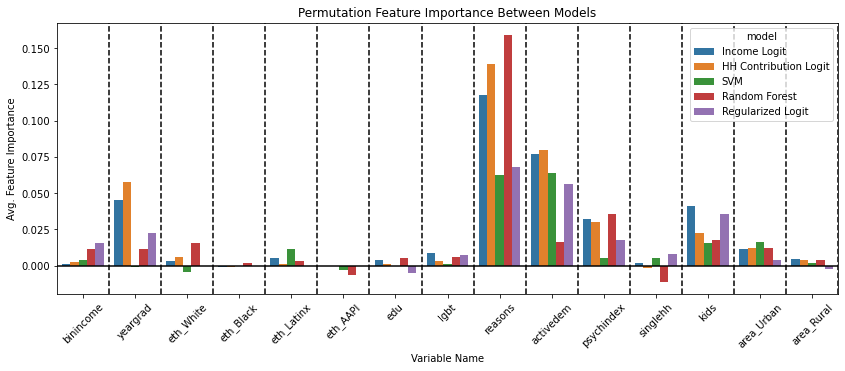

In [13]:
graph_data = {}
for model_name, model in models:
    perm_importance = permutation_importance(model, X_test, y_test)
    graph_data[model_name] = perm_importance.importances_mean
    
# make final dataframe
graph_data = pd.DataFrame.from_dict(graph_data, orient='index', columns=X_inc.columns)
graph_data_c = graph_data[["binincome", "yeargrad", "eth_White", "eth_Black", "eth_Latinx", "eth_AAPI", "edu", 
           "lgbt", "reasons", "activedem", "psychindex", "singlehh", "kids", "area_Urban", "area_Rural"]]
graph_data_c.reset_index(inplace=True, drop=False)
graph_data_c.rename(columns={'index': 'model'}, inplace=True)
graph_data_c = graph_data_c.melt(id_vars='model')

# create visual
plt.figure(figsize=[14,5])
plt.axhline(0, c='black')
[plt.axvline(i + 0.5, linestyle='--', c='black') for i in range(0, len(X_inc.columns))]
ax = sns.barplot(x=graph_data_c['variable'], y=graph_data_c['value'], hue=graph_data_c['model'])
plt.title("Permutation Feature Importance Between Models")
plt.xlabel("Variable Name")
plt.ylabel("Avg. Feature Importance")
plt.xticks(rotation=45)
plt.show()